# Zooplankton response to Aug 2017 eclipse

OOI Data Labs Education Nuggets

This tutorial was adapted from the notebook provided in the [echopype package](https://github.com/OSOceanAcoustics/echopype), which explains how to download and process raw echosounder data from the OOI raw data server. This package and notebook were originally written by [Wu-Jung Lee](https://leewujung.github.io/). See Wu-Jung's additional blog post about the [eclipse](https://leewujung.github.io/post/2018-07-30-wacthing-eclipse-from-ooi-sonar/) and [ground-truthing](https://leewujung.github.io/post/2018-07-25-scooping-up-zooplankton-from-the-ocean/) the OOI echo sounders.

_Notebook modified by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on June 22, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download solar radiation data from a Surface Mooring Bulk Meteorology instrument via the OOI Machine-to-Machine interface, download raw echo sounder data from the OOI raw data server, process the raw data files using echopype, and plot both the solar radiation and echo sounder data.

The echo sounder we will use for this example is located on the Oregon Offshore Cabled Shallow Profiler Mooring (CE04OSPS) and is a Kongsberg EK-60 deployed at 200m depth looking up. You can find more information about the cabled echosounders [here](https://oceanobservatories.org/instrument-series/zplscb/). Since we want to see how zooplankton respond to an eclipse that occured on Aug 21, 2017, we also want to look at the solar radiation data at this location. There is an Endurance Surface Mooring deployed at the same location (seen at #3 in the schematic [here](https://oceanobservatories.org/wp-content/uploads/2018/03/CEV-OOI-Endurance-Array.jpg)) that has a Bulk Meteorology Instrument Package (CE04OSSM-SBD11-06-METBKA000) that measures Downwelling Shortwave Irradiance. First, we will download the METBK data from OOINet via the Machine-to-Machine interface to determine if we can see the signal of the eclipse in the solar radiation data.

The OOI echo sounder data is not processed via OOINet, so we will need to download the raw data files from the [OOI raw data server](https://oceanobservatories.org/data/raw-data/) and process them ourselves into a usable format. Luckily, the [echopype package](https://github.com/OSOceanAcoustics/echopype) makes that very easy to do. The OOI raw data server is often difficult to navigate for users that are unfamiliar with the OOI cyberinfrastructure, but really all you need to know are the components of the instrument's code, which is called the reference designator. In this case, we are looking for data associated with the reference designator CE04OSPS-PC01B-05-ZPLSCB102. The location of the raw data files for this instrument in August of 2017 is: https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08

If you access the [higher level directory](https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/) in the raw data server where you can navigate to multiple instruments on the same platform, there are actually 2 directories that contain the echo sounder data:
* 05-ZPLSCB102/
* ZPLSCB102_10.33.10.143/

This is because the OOI has 2 systems that log data from this instrument. The .raw data files should be identical as they are pulled directly from the instrument. The only difference is the folder structure, so I chose to use the ZPLSCB102_10.33.10.143/ directory because there are fewer folders through which to navigate.

In [1]:
# Packages required for data processing and plotting
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
from echopype.convert import Convert
from echopype.model import EchoData

In [4]:
import netCDF4 as nc

In [5]:
#pip install echopype

## Request Data from OOINet

First, we will download the Bulk Met data from OOINet via the Machine-to-Machine interface.

**Coastal Endurance Oregon Offshore Surface Mooring (CE04OSSM)**
* METBK
    * Instrument: CE04OSSM-SBD11-06-METBKA000
    * Data stream: metbk_a_dcl_instrument_recovered
    * Parameters: shortwave_irradiance
* Time range: 2017-08-21 to 2017-08-22
* Delivery method: recovered_host

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

To request data from OOINet you need to enter your username and token below. You also need to specify a local directory where the echosounder files and output plots can be saved.

In [42]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = 'OOIAPI-xxxx'
API_TOKEN = 'TEMP-TOKEN-xxxx'
save_dir = '/Users/Derya/Documents/GitHub/nuggets-notebooks/extras/'

In [7]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the METBK via the Machine-to-Machine interface. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [8]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-08-21T00:00:00.000Z', '2017-08-22T12:00:00.000Z')

# print('METBK_url = %s' %METBK_url)

## Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [9]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [10]:
url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc'
url_with_fillmismatch = f'{url}#fillmismatch'
ds = xr.open_dataset(url_with_fillmismatch)
print(ds)
#with nc.Dataset(url_with_fillmismatch) as nc_ds:
    #print(nc_ds)

<xarray.Dataset>
Dimensions:                                   (obs: 2160)
Coordinates:
  * obs                                       (obs) int32 0 1 2 ... 2158 2159
Data variables: (12/79)
    met_heatflx_minute                        (obs) float64 ...
    met_current_direction_qc_results          (obs) float32 ...
    met_relwind_direction                     (obs) float64 ...
    northward_wind_velocity_qc_executed       (obs) float32 ...
    met_windavg_mag_corr_east                 (obs) float64 ...
    shortwave_irradiance_qc_results           (obs) float32 ...
    ...                                        ...
    time                                      (obs) datetime64[ns] ...
    met_relwind_speed                         (obs) float64 ...
    met_current_speed_qc_executed             (obs) float32 ...
    shortwave_irradiance_qc_executed          (obs) float32 ...
    met_netsirr_qc_executed                   (obs) float32 ...
    met_netsirr                               (o

In [11]:
url = 'https://opendap.oceanobservatories.org/thredds/dodsC//ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc'
url_with_fillmismatch = f'{url}#fillmismatch'
ds = xr.open_dataset(url_with_fillmismatch, mask_and_scale=False)
print(url)
print(url_with_fillmismatch)
print(ds)
#with nc.Dataset(url_with_fillmismatch) as nc_ds:
    #print(nc_ds)

https://opendap.oceanobservatories.org/thredds/dodsC//ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc
https://opendap.oceanobservatories.org/thredds/dodsC//ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc#fillmismatch
<xarray.Dataset>
Dimensions:                                   (obs: 2160)
Coordinates:
  * obs                                       (obs) int32 0 1 2 ... 2158 2159
Data variables: (12/79)
    met_heatflx_minute                        (obs) float64 ...
    met_current_direction_qc_results          (obs) int8 ...
    met_relwind_direction                     (obs) floa

In [12]:
path1 = 'https://opendap.oceanobservatories.org/thredds/dodsC'
path2 = 'catalog.html?dataset=ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc'
os.path.join(path1, path2.split('=')[-1]).replace("\\","/")


'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc'

In [13]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]).replace("\\","/") for i in x]
    #print('tds_url', tds_url)
    #print('x', x)
    #print('aa', [os.path.join(tds_url, i.split('=')[-1]).replace("\\","/") for i in x])

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
   # print('Appending data from files')
   # print(selected_datasets)
    
    #url_with_fillmismatch = f'{url}#fillmismatch'
    #ds = xr.open_dataset(url_with_fillmismatch)
    
    
    for sd in selected_datasets:
        print('sd', sd)
       # url = 'https://opendap.oceanobservatories.org/thredds/dodsC//ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc'
       # print('url', url)
        url_with_fillmismatch = f'{sd}#fillmismatch'
        ds = xr.open_dataset(url_with_fillmismatch, mask_and_scale=False)
       # print(ds.head())
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

In [14]:
# Specify the variable and get the data from the file(s)
METBKvars = ['shortwave_irradiance']
METBK_data, METBK_units = get_data(METBK_url, METBKvars)
print(METBK_units)

sd https://opendap.oceanobservatories.org/thredds/dodsC/ooi/deryag@uw.edu/20210418T185706089Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0004_CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20170821T000003.797000-20170822T115857.652000.nc
{'shortwave_irradiance': ['W m-2']}


In [15]:
# print out the first few lines of the METBK dataset
METBK_data.head()

,time,shortwave_irradiance
0,2017-08-21 00:00:03.796999680,518.200012
1,2017-08-21 00:01:08.644000256,482.000000
2,2017-08-21 00:02:12.951000064,473.799988
3,2017-08-21 00:03:17.189000192,466.500000
4,2017-08-21 00:04:22.203999744,486.700012


## Quick Data Plot
First, let's make a quick data plot of the solar radiation data on the day the eclipse happened.

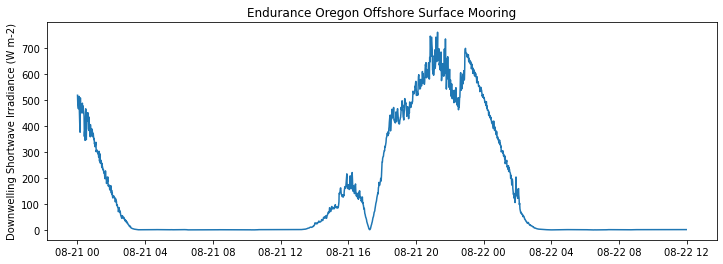

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(METBK_data['time'], METBK_data['shortwave_irradiance'])
ax.set_title('Endurance Oregon Offshore Surface Mooring')
ax.set_ylabel('Downwelling Shortwave Irradiance ({})'.format(METBK_units['shortwave_irradiance'][0]));

Cool!! Keep in mind that all of the timestamps for OOI data are in UTC. We can see the solar radiation start to increase the morning of Aug 21, then around 17:00 UTC the solar radiation drops down to zero right when the eclipse happens. These instruments are located in Pacific Daylight Time (7 hours behind UTC) so according to these data, the eclipse occurred somewhere around 10:00 AM PDT.

Let's export this dataset as a .csv file.

In [17]:
# rename and add units to the columns
METBK_data = METBK_data.rename(columns={'shortwave_irradiance': 'Downwelling Shortwave Irradiance ({})'.format(METBK_units['shortwave_irradiance'][0])})

# round data to 2 decimal places
METBK_data = METBK_data.round(2)
METBK_data.head()

,time,Downwelling Shortwave Irradiance (W m-2)
0,2017-08-21 00:00:03.796999680,518.2
1,2017-08-21 00:01:08.644000256,482.0
2,2017-08-21 00:02:12.951000064,473.8
3,2017-08-21 00:03:17.189000192,466.5
4,2017-08-21 00:04:22.203999744,486.7


In [18]:
# export the data to .csv
print(save_dir)
METBK_data.to_csv('E04_CE04OSSM_METBK_eclipse.csv', index=False)

/Users/Derya/Documents/GitHub/nuggets-notebooks/extras/


## Download raw echo sounder data

In order to process the echo sounder data, first we need to download the raw data files from the OOI raw data server. We will save the files to the local directory you specified at the beginning of the notebook, and once the files are processed into a usable format we will delete the raw data files. In order to download those files, we'll use a package called [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) that makes it easy to parse content from websites.

In [32]:
# download raw echosounder data files that encompass the same time range of the METBK data above
ooi_raw_url = 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22'
start_time = dt.datetime(2017, 8, 21, 0, 0)
end_time = dt.datetime(2017, 8, 22, 12, 0)

# parse the contents of the webpage using the BeautifulSoup package
page = requests.get(ooi_raw_url).text
soup = BeautifulSoup(page, 'html.parser')

# find all of the items in the webpage that end in '.raw' and append those urls to a list
urls = [ooi_raw_url + '/' + item for item in soup.find_all(text=True) if '.raw' in item]
#print(urls)

# identify the list of urls in the date range specified
range_urls = []
for url in urls:
    print(url)
    url_date = dt.datetime.strptime(url[-20:-4], '%Y%m%d-T%H%M%S')
    print(url_date)
    if start_time <= url_date <= end_time:
        range_urls.append(url)
        print(range_urls)
        
# download raw data files to the local directory specified above
# this will take several minutes
rawfiles = []
for url in range_urls:
    r = requests.get(url, allow_redirects=True)
    fname = os.path.join(save_dir, os.path.basename(url))
    rawfiles.append(fname)
    print('Downloading {}'.format(fname))
    open(fname, 'wb').write(r.content)

https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T000000.raw
2017-08-22 00:00:00
['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T000000.raw']
https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T013902.raw
2017-08-22 01:39:02
['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T000000.raw', 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T013902.raw']
https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T031804.raw
2017-08-22 03:18:04
['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2017/08/22/OOI-D20170822-T000000.raw', 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/2

Now, using the echopype package, we can process the raw data files and convert them to NetCDF, then delete the raw files from our computer since we won't need those anymore.

In [33]:
# convert from raw file to netCDF
for filename in rawfiles:
    data_tmp = Convert(filename)
    data_tmp.platform_name = 'CE04OSPS'
    data_tmp.platform_type = 'OOI Oregon Offshore Cabled Shallow Profiler Mooring'
    data_tmp.platform_code_ICES = '3164' # ICES SHIPC platform code for moorings
    data_tmp.raw2nc()
    os.remove(filename)  # delete raw data files

16:39:30  converting file: OOI-D20170822-T000000.raw
16:39:37  converting file: OOI-D20170822-T013902.raw
16:39:45  converting file: OOI-D20170822-T031804.raw
16:39:52  converting file: OOI-D20170822-T045705.raw
16:40:00  converting file: OOI-D20170822-T063606.raw
16:40:07  converting file: OOI-D20170822-T081508.raw
16:40:15  converting file: OOI-D20170822-T095414.raw
16:40:22  converting file: OOI-D20170822-T113315.raw


Once the raw files are converted to NetCDF, we can use some other functions provided by the echopype package to calibrate the data, obtain volume backscattering strength (Sv) and calculate mean volume backscattering strength (MVBS). You can specify the degree of averaging and binning in the calculation of MVBS by setting the MVBS_range_bin_size and MVBS_ping_size parameters. Here we won't save Sv to disk (you can do so by specifying ed.calibrate(save=True)), but we will save MVBS to NetCDF files on your local machine.

In [34]:
save_dir

'../downloads/'

In [35]:
ncfiles = sorted(glob.glob(os.path.join(save_dir, '*.nc')))
for filename in ncfiles:
    ed = EchoData(filename) # create an echo data processing object
    ed.calibrate() # obtain volume backscattering strength (Sv)
    ed.get_MVBS(MVBS_range_bin_size=1, MVBS_ping_size=10, save=True)
    os.remove(filename)  # delete intermediate data files

<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:30  calibrating data in ../downloads\OOI-D20170821-T000000.nc
16:40:31  use Sv stored in memory to calculate MVBS
16:40:32  saving MVBS to ../downloads\OOI-D20170821-T000000_MVBS.nc
16:40:32  calibrating data in ../downloads\OOI-D20170821-T013914.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:33  use Sv stored in memory to calculate MVBS
16:40:33  saving MVBS to ../downloads\OOI-D20170821-T013914_MVBS.nc
16:40:34  calibrating data in ../downloads\OOI-D20170821-T031816.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:34  use Sv stored in memory to calculate MVBS
16:40:35  saving MVBS to ../downloads\OOI-D20170821-T031816_MVBS.nc
16:40:35  calibrating data in ../downloads\OOI-D20170821-T045717.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:36  use Sv stored in memory to calculate MVBS
16:40:37  saving MVBS to ../downloads\OOI-D20170821-T045717_MVBS.nc
16:40:37  calibrating data in ../downloads\OOI-D20170821-T063618.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:38  use Sv stored in memory to calculate MVBS
16:40:38  saving MVBS to ../downloads\OOI-D20170821-T063618_MVBS.nc
16:40:39  calibrating data in ../downloads\OOI-D20170821-T081522.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:39  use Sv stored in memory to calculate MVBS
16:40:40  saving MVBS to ../downloads\OOI-D20170821-T081522_MVBS.nc
16:40:40  calibrating data in ../downloads\OOI-D20170821-T095435.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:41  use Sv stored in memory to calculate MVBS
16:40:42  saving MVBS to ../downloads\OOI-D20170821-T095435_MVBS.nc
16:40:42  calibrating data in ../downloads\OOI-D20170821-T113343.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:43  use Sv stored in memory to calculate MVBS
16:40:43  saving MVBS to ../downloads\OOI-D20170821-T113343_MVBS.nc
16:40:43  calibrating data in ../downloads\OOI-D20170821-T131245.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:44  use Sv stored in memory to calculate MVBS
16:40:45  saving MVBS to ../downloads\OOI-D20170821-T131245_MVBS.nc
16:40:45  calibrating data in ../downloads\OOI-D20170821-T145147.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:46  use Sv stored in memory to calculate MVBS
16:40:47  saving MVBS to ../downloads\OOI-D20170821-T145147_MVBS.nc
16:40:47  calibrating data in ../downloads\OOI-D20170821-T163049.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:48  use Sv stored in memory to calculate MVBS
16:40:48  saving MVBS to ../downloads\OOI-D20170821-T163049_MVBS.nc
16:40:48  calibrating data in ../downloads\OOI-D20170821-T180952.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:49  use Sv stored in memory to calculate MVBS
16:40:50  saving MVBS to ../downloads\OOI-D20170821-T180952_MVBS.nc
16:40:50  calibrating data in ../downloads\OOI-D20170821-T194853.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:51  use Sv stored in memory to calculate MVBS
16:40:52  saving MVBS to ../downloads\OOI-D20170821-T194853_MVBS.nc
16:40:52  calibrating data in ../downloads\OOI-D20170821-T212802.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:52  use Sv stored in memory to calculate MVBS
16:40:53  saving MVBS to ../downloads\OOI-D20170821-T212802_MVBS.nc
16:40:53  calibrating data in ../downloads\OOI-D20170821-T230706.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:54  use Sv stored in memory to calculate MVBS
16:40:54  saving MVBS to ../downloads\OOI-D20170821-T230706_MVBS.nc
16:40:54  calibrating data in ../downloads\OOI-D20170822-T000000.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:55  use Sv stored in memory to calculate MVBS
16:40:56  saving MVBS to ../downloads\OOI-D20170822-T000000_MVBS.nc
16:40:56  calibrating data in ../downloads\OOI-D20170822-T013902.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:57  use Sv stored in memory to calculate MVBS
16:40:57  saving MVBS to ../downloads\OOI-D20170822-T013902_MVBS.nc
16:40:57  calibrating data in ../downloads\OOI-D20170822-T031804.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:40:58  use Sv stored in memory to calculate MVBS
16:40:59  saving MVBS to ../downloads\OOI-D20170822-T031804_MVBS.nc
16:40:59  calibrating data in ../downloads\OOI-D20170822-T045705.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:41:00  use Sv stored in memory to calculate MVBS
16:41:01  saving MVBS to ../downloads\OOI-D20170822-T045705_MVBS.nc
16:41:01  calibrating data in ../downloads\OOI-D20170822-T063606.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:41:02  use Sv stored in memory to calculate MVBS
16:41:02  saving MVBS to ../downloads\OOI-D20170822-T063606_MVBS.nc
16:41:02  calibrating data in ../downloads\OOI-D20170822-T081508.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:41:03  use Sv stored in memory to calculate MVBS
16:41:04  saving MVBS to ../downloads\OOI-D20170822-T081508_MVBS.nc
16:41:04  calibrating data in ../downloads\OOI-D20170822-T095414.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:41:05  use Sv stored in memory to calculate MVBS
16:41:06  saving MVBS to ../downloads\OOI-D20170822-T095414_MVBS.nc
16:41:06  calibrating data in ../downloads\OOI-D20170822-T113315.nc


<ipython-input-35-0b360ca44a21>:3: DeprecationWarning: Echodata has been renamed to Process and will no longer be supported in the future.
  ed = EchoData(filename) # create an echo data processing object


16:41:06  use Sv stored in memory to calculate MVBS
16:41:07  saving MVBS to ../downloads\OOI-D20170822-T113315_MVBS.nc


## Explore and plot echo sounder data

Now we can access the processed echo sounder data, explore the data a bit, and create plots to visualize zooplankton biomass.

In [36]:
# open all of the MVBS.nc files as one dataset
mvbs_data = xr.open_mfdataset(os.path.join(save_dir, '*MVBS.nc'), 
                              combine='by_coords', data_vars='different')

# Add depth as a new coordinate
depth = mvbs_data.range_bin * mvbs_data.MVBS_range_bin_size
mvbs_data.coords['depth'] = (['range_bin', 'frequency'], depth[::-1])
print(mvbs_data)

<xarray.Dataset>
Dimensions:              (frequency: 3, ping_time: 13333, range_bin: 215)
Coordinates:
  * frequency            (frequency) float32 1.2e+05 3.8e+04 2e+05
  * ping_time            (ping_time) datetime64[ns] 2017-08-21T00:00:05.47380...
  * range_bin            (range_bin) int32 0 1 2 3 4 5 ... 210 211 212 213 214
    depth                (range_bin, frequency) float64 204.6 204.6 ... 0.0 0.0
Data variables:
    MVBS                 (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 593, 215), meta=np.ndarray>
    MVBS_range_bin_size  (frequency) float64 dask.array<chunksize=(3,), meta=np.ndarray>
Attributes:
    MVBS_ping_size:  10


In [37]:
# look at part of the depth variable
mvbs_data.depth.values[0:20]

array([[204.6030087 , 204.6030087 , 204.6030087 ],
       [203.64691988, 203.64691988, 203.64691988],
       [202.69083105, 202.69083105, 202.69083105],
       [201.73474223, 201.73474223, 201.73474223],
       [200.7786534 , 200.7786534 , 200.7786534 ],
       [199.82256457, 199.82256457, 199.82256457],
       [198.86647575, 198.86647575, 198.86647575],
       [197.91038692, 197.91038692, 197.91038692],
       [196.9542981 , 196.9542981 , 196.9542981 ],
       [195.99820927, 195.99820927, 195.99820927],
       [195.04212045, 195.04212045, 195.04212045],
       [194.08603162, 194.08603162, 194.08603162],
       [193.12994279, 193.12994279, 193.12994279],
       [192.17385397, 192.17385397, 192.17385397],
       [191.21776514, 191.21776514, 191.21776514],
       [190.26167632, 190.26167632, 190.26167632],
       [189.30558749, 189.30558749, 189.30558749],
       [188.34949867, 188.34949867, 188.34949867],
       [187.39340984, 187.39340984, 187.39340984],
       [186.43732101, 186.43732

In [38]:
# look at the timestamps
mvbs_data.ping_time.values

array(['2017-08-21T00:00:05.473800192', '2017-08-21T00:00:15.604499968',
       '2017-08-21T00:00:25.634599936', ...,
       '2017-08-22T13:11:58.472300032', '2017-08-22T13:12:08.502099968',
       '2017-08-22T13:12:15.021999616'], dtype='datetime64[ns]')

Here we see the resolution of the MVBS echo sounder data based on the parameters we set in the ed.get_MVBS function above (MVBS_range_bin_size=1, MVBS_ping_size=10). Here we have 10 second averages in 1 m depth bins - you can change these parameters and re-process the MVBS data if you don't want such a high-resolution dataset to save some disk space.

In [39]:
mvbs_data.frequency

<xarray.DataArray 'frequency' (frequency: 3)>
array([120000.,  38000., 200000.], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 1.2e+05 3.8e+04 2e+05
Attributes:
    units:      Hz
    valid_min:  0.0

This echo sounder collects data at three frequencies: 38 kHz, 120 kHz, and 200 kHz. In general, higher frequencies detect smaller organisms. For example, the 38 kHz frequency could detect fish while 120 kHz could give an idea of the amount of larger zooplankton (such as krill) and 200 kHz can detect smaller zooplankton such as copepods. There can be some overlap between the types of organisms that are detected at different frequencies (e.g. krill can be detected at 120 and 200 kHz), and an organism's acoustic signature varies with other factors such as body composition and orientation in the water column. The only way to really determine what species are detected by an echosounder at any time is by ground-truthing the backscatter measurements with zooplankton and fish collected at that location with net tows.

For this example, we'll grab the data collected at 200 kHz. This will generally give us an idea about the abundance and distribution of smaller zooplankton. We need to make sure to grab only the data within our requested time range so that it will match up with the solar radiation data from the METBK. Earlier we selected the raw echosounder files based on time, but the last file will contain data beyond the requested timestamp.

<ipython-input-40-9e4132116321>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = ax.pcolormesh(MVBS_200k.ping_time.values, MVBS_200k.depth.values, MVBS_200k.values.T,


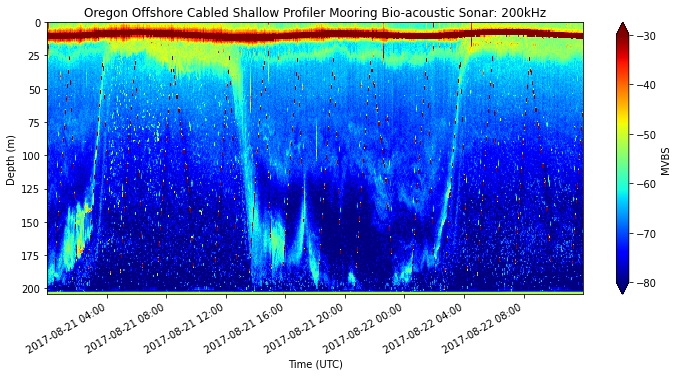

In [40]:
# get the data at 200 kHz at the specified time
MVBS_200k = mvbs_data.MVBS.sel(frequency=200000).sel(ping_time=slice('2017-08-21 00:00:00', 
                                                                     '2017-08-22 12:00:00'))
MVBS_200k = MVBS_200k.swap_dims({'range_bin': 'depth'})

# plot MVBS data
fig, ax = plt.subplots(figsize=(12, 6))
h = ax.pcolormesh(MVBS_200k.ping_time.values, MVBS_200k.depth.values, MVBS_200k.values.T, 
                  vmin=-80, vmax=-30, cmap='jet')

# add the color bar
cb = plt.colorbar(h, extend='both')
cb.set_label(label='MVBS')

# add labels
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time (UTC)')
ax.set_title('Oregon Offshore Cabled Shallow Profiler Mooring Bio-acoustic Sonar: 200kHz')

ax.invert_yaxis()

# format the date axis
df = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(df)
fig.autofmt_xdate()
plt.subplots_adjust(bottom=0.25)

# save the figure to your local machine
figname = 'CE04OSPS_echosounder_20170821.png'
sfig = os.path.join(save_dir, figname)
plt.savefig(sfig, dpi=200)

First, notice the noise at the surface (which also demonstrates the tidal signal) and the zooplankton ascending and descending in the water column (the green colors). One other thing to note is the profiler on the mooring which is the dotted dark red line that is moving up and down in the water column several times a day. Now, let's add the METBK data to see the correlation between solar radiation and zooplankton.

<ipython-input-41-c2c1f2251415>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = ax2.pcolormesh(MVBS_200k.ping_time.values, MVBS_200k.depth.values, MVBS_200k.T,


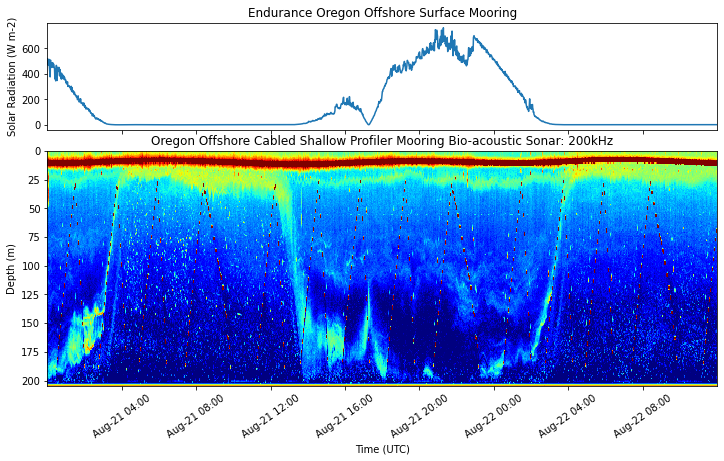

In [41]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

# plot METBK solar radiation data
ax1.plot(METBK_data['time'], METBK_data['Downwelling Shortwave Irradiance (W m-2)'])
ax1.set_title('Endurance Oregon Offshore Surface Mooring')
ax1.set_ylabel('Solar Radiation ({})'.format(METBK_units['shortwave_irradiance'][0]))
plt.setp(ax1.get_xticklabels(), visible=False)

# set the x limits to the min and max METBK timestamp to get rid of extra white space in the graph
ax1.set_xlim([np.nanmin(METBK_data['time']), np.nanmax(METBK_data['time'])])

# plot echosounder data
h = ax2.pcolormesh(MVBS_200k.ping_time.values, MVBS_200k.depth.values, MVBS_200k.T, 
                   vmin=-80, vmax=-30, cmap='jet')

ax2.set_ylabel('Depth (m)')
ax2.set_xlabel('Time (UTC)')
ax2.set_title('Oregon Offshore Cabled Shallow Profiler Mooring Bio-acoustic Sonar: 200kHz')

ax2.invert_yaxis()

# format the date axis
df = mdates.DateFormatter('%b-%d %H:%M')
ax2.xaxis.set_major_formatter(df)
plt.xticks(rotation=35)
plt.subplots_adjust(bottom=0.25)

# save the figure to your local machine
figname = 'CE04OSPS_eclipse.png'
sfig = os.path.join(save_dir, figname)
plt.savefig(sfig, dpi=200)

Here we can visualize the vertical migration of zooplankton as it relates to solar radiation - the zooplankton are at depth during the day and migrate to the surface at night. As the solar radiation increases on Aug 21, they descend back to deeper waters. Then, right when the eclipse happens around 17:00 UTC, the zooplankton are tricked into thinking it's dusk and briefly start to ascend again until the eclipse passes and they go back down to depth where they remain for the rest of the daylight hours.